# Homework 1 Exploratory Data Analysis of the Wikispeedia dataset

Import all the relevent libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

## Read the file 

In [2]:
paths_graph_columns = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
paths_graph = pd.read_csv('data/wikispeedia_paths-and-graph.tar.gz', compression='gzip', names = paths_graph_columns, sep = '\t', skiprows=range(15), header = None)
paths_graph

C:\Users\mathi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166.0,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88.0,14th_century;Europe;Africa;Atlantic_slave_trad...,3
2,415612e93584d30e,1349298640,138.0,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37.0,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175.0,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3
...,...,...,...,...,...
210549,______33333434523232434_2332544324_3_323333544...,NaN,NaN,NaN,NaN
210550,______22222424522231434_2322545434_3_422232544...,NaN,NaN,NaN,NaN
210551,______33333436733342435_2433545444_3_523353544...,NaN,NaN,NaN,NaN
210552,______22233325623232434_2423544334_3_423343544...,NaN,NaN,NaN,NaN


## Handling missing data

We replace values that are not between 1 and 5 in the rating to -1 so that we don't remove rows that only do not have a rating. 

Then we remove all the rows that have NaN since there is only rows that are all NaN or none.

In [3]:
paths_graph[(paths_graph['path'] != np.NaN) & (paths_graph['timestamp'] == np.NaN) ]

,hashedIpAddress,timestamp,durationInSec,path,rating


In [4]:
paths_graph['rating'] = paths_graph['rating'].apply(lambda s : -1 if not str(s).isdigit() else s).astype(int)
paths_graph.dropna(inplace = True)

In [5]:
# Add the length of the paths and the destination
paths_graph.insert(0, 'path_id',  paths_graph.index)
paths_graph['destination'] = paths_graph['path'].apply(lambda x : str(x).split(';')[-1])
paths_graph['pathLength'] = paths_graph['path'].apply(lambda x : len(str(x).split(';')))
paths_graph.head()

,path_id,hashedIpAddress,timestamp,durationInSec,path,rating,destination,pathLength
0,0,6a3701d319fc3754,1297740409,166.0,14th_century;15th_century;16th_century;Pacific...,-1,African_slave_trade,9
1,1,3824310e536af032,1344753412,88.0,14th_century;Europe;Africa;Atlantic_slave_trad...,3,African_slave_trade,5
2,2,415612e93584d30e,1349298640,138.0,14th_century;Niger;Nigeria;British_Empire;Slav...,-1,African_slave_trade,8
3,3,64dd5cd342e3780c,1265613925,37.0,14th_century;Renaissance;Ancient_Greece;Greece,-1,Greece,4
4,4,015245d773376aab,1366730828,175.0,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3,John_F._Kennedy,7


## Edges dataframe 

We create a second dataframe that carry the all the pages visited during the paths with order and use it to create all edges representing paths that players used during their game.

We then create a network with it 

##### ToDo
We still need to handle the '>' sign in the paths 

In [6]:
paths = paths_graph[['path_id', 'path']].copy()
paths['path'] = paths['path'].apply(lambda x : str(x).split(';'))
paths = paths.explode('path').reset_index().rename(columns={'path': 'page', 'index' : 'page_index_in_path'})
paths['page_index_in_path'] = paths.groupby('page_index_in_path').cumcount()
paths.head()

#Need to handle >
start_edges = paths_graph[['path_id', 'path']].copy()
start_edges.loc[:,'path'] = start_edges['path'].apply(lambda x : str(x).split(';')[:-1])
start_edges = start_edges.explode('path').reset_index().rename(columns={'path': 'start_edge', 'index' : 'page_index_in_path'})

end_edges =  paths_graph[['path_id', 'path']].copy()
end_edges.loc[:,'path'] = end_edges['path'].apply(lambda x : str(x).split(';')[1:])
end_edges = end_edges.explode('path').reset_index().rename(columns={'path': 'end_edge', 'index' : 'page_index_in_path'})

edges = pd.concat([start_edges.start_edge, end_edges.end_edge],axis = 1)
edges = edges.groupby(['start_edge', 'end_edge']).agg(len).reset_index().rename(columns  = {0 : 'weight'})

G=nx.from_pandas_edgelist(edges, 'start_edge', 'end_edge', 'weight')

Then we can get some statistics on the graph like 
- find shortest path from two pages 
- get all the neighbors of a page
- etc.

In [7]:
#Get shortest path from two pages 
for path in nx.shortest_path(G, '14th_century', 'Tennis'):
    print(path)

14th_century
<
Tennis


In [8]:
def best_neighbor_of(page):
    neighbors = [(a, b['weight']) for a,b in dict(G[page]).items()]
    neighbors.sort(key= lambda x : x[1], reverse = True)
    return neighbors
best_neighbor_of('Theatre')[:20]

[('India', 303),
 ('United_States', 241),
 ('Dance', 161),
 ('Brazil', 138),
 ('France', 134),
 ('United_Kingdom', 121),
 ('Actor', 106),
 ('Music', 100),
 ('Aristotle', 97),
 ('Paris', 72),
 ('Stage_%28theatre%29', 70),
 ('Drama', 64),
 ('Opera', 62),
 ('Existentialism', 44),
 ('Art', 29),
 ('Lighting_designer', 24),
 ('Globe_Theatre', 11),
 ('<', 9),
 ('Australia', 8),
 ('House', 8)]

In [16]:
best_neighbor_of('Rome')[:20]

[('Italy', 76),
 ('Ancient_Rome', 68),
 ('Roman_Empire', 54),
 ('Ancient_Greece', 36),
 ('<', 29),
 ('England', 29),
 ('Capital', 27),
 ('European_Union', 26),
 ('Renaissance', 23),
 ('World_War_II', 22),
 ('Europe', 20),
 ('Roman_Catholic_Church', 15),
 ('Christianity', 15),
 ('Heracles', 14),
 ('Temperate', 12),
 ('Trojan_War', 12),
 ('Capitoline_Triad', 8),
 ('Michelangelo', 8),
 ('Pope', 8),
 ('Roman_villa', 8)]

## Find most visited pages 

Look at words that appears a lot and could be the general concepts 

In [10]:
most_general_concepts = paths.page.value_counts()
most_general_concepts[:5]

<                 33465
United_States     12449
Europe             5610
United_Kingdom     5328
England            4558
Name: page, dtype: int64

## Players statistics 

We could be interested in what are the best players, if they played a lot and if they get better by playing many games 

In [11]:
#Who has the best scores 
print(paths_graph.iloc[paths_graph.durationInSec.idxmin()].head(5))


#And look at stats of the different players 
stats_by_ip_addr = paths_graph.groupby('hashedIpAddress').agg({'durationInSec' : [np.median, np.mean, min , max ,len]})
stats_by_ip_addr = stats_by_ip_addr.sort_values(by = ('durationInSec',    'len'), ascending = False)
stats_by_ip_addr.head(5)

path_id                        5857
hashedIpAddress    43f864c75b2571b5
timestamp                1350587401
durationInSec                   0.0
path                        Lesotho
Name: 5857, dtype: object


durationInSec                                
                        median        mean  min      max   len
hashedIpAddress                                               
0d57c8c57d75e2f5         110.0  162.040493  2.0  10670.0  4865
473d6ac602c2b198         109.0  250.158556  9.0   2829.0   637
7d5624e35c9523ef          54.0  134.055980  2.0   3861.0   393
5bb5836b425e6bfe          59.0  221.211039  3.0   2317.0   308
75bd20c663d02c8f         116.0  354.090909  8.0   4099.0   297

We can also look at the distribution of the number of game played by the players which appears to be a power law

<AxesSubplot:>

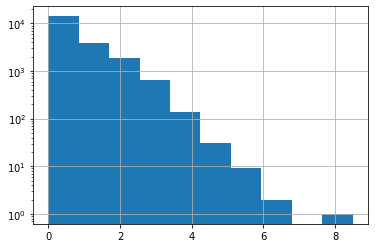

In [12]:
np.log(stats_by_ip_addr[('durationInSec', 'len')]).hist(log = True)

There are 0.374078 of the instances of the game than were rated


C:\Users\mathi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


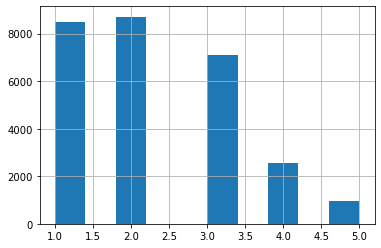

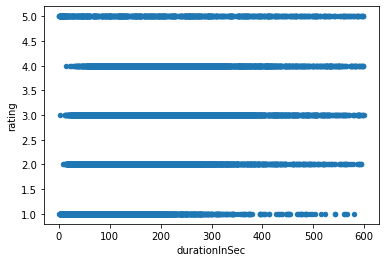

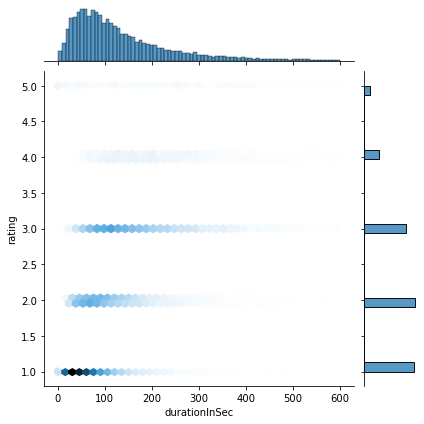

In [13]:
interesting_rating = paths_graph[(paths_graph['durationInSec']< 600) & (paths_graph['rating']>0)].copy()
rating_percentage = len(paths_graph[paths_graph['rating']>0])/len(paths_graph)
print(f"There are %f of the instances of the game than were rated"%(rating_percentage))
interesting_rating.rating.hist()
interesting_rating.plot.scatter('durationInSec', 'rating')
sns.jointplot(interesting_rating.durationInSec, interesting_rating.rating, kind="hex")

<AxesSubplot:>

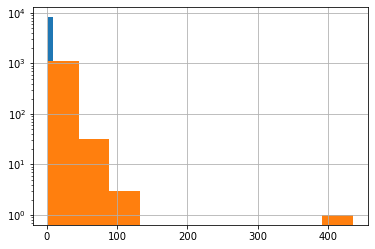

In [14]:

paths_graph[paths_graph['rating']==1].pathLength.hist(log = True)

paths_graph[paths_graph['rating']==5].pathLength.hist(log = True)

In [15]:
paths_graph[paths_graph['rating']==5].path

13       14th_century;Renaissance;Empiricism;Nature;Wea...
41       14th_century;Europe;<;England;<;Christianity;A...
62       2005_Atlantic_hurricane_season;Europe;Liechten...
73       Aberdeen;Europe;Romania;Football_%28soccer%29;...
88       Acceleration;Sea;Hudson_Bay;Atlantic_Ocean;Cod...
                               ...                        
51152    Llandudno;United_Kingdom;Opera;Porgy_and_Bess;...
51249    StarCraft;South_Korea;United_States;Agricultur...
51250    StarCraft;South_Korea;United_States;Rocky_Moun...
51251    StarCraft;Internet;North_America;United_States...
51310    Women%27s_rights;Property;Clothing;Weather;Autumn
Name: path, Length: 1158, dtype: object

In [1]:
import urllib.parse as urlp
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
graph_columns = ['Source', 'Target']
graph = pd.read_csv('data/links.tsv', names = graph_columns, sep = '\t', skiprows=range(12), header = None)
graph

,Source,Target
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


Source
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in    11
%C3%85land                          19
%C3%89douard_Manet                  20
%C3%89ire                            8
%C3%93engus_I_of_the_Picts          10
                                    ..
Zionism                             74
Zirconium                           42
Zoroaster                           28
Zuid-Gelders                         5
Zulu                                15
Length: 4587, dtype: int64


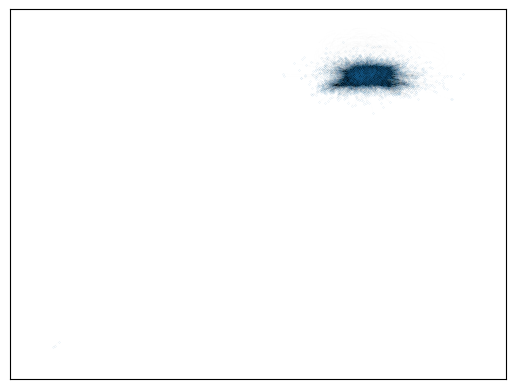

In [6]:
node_frame = graph.groupby('Source')
print(node_frame.size())

G=nx.from_pandas_edgelist(graph, 'Source', 'Target')
nx.draw_networkx(G,node_size= 0.002,with_labels=False, width = 0.001 )

In [8]:
#Is graph connected
nx.is_connected(G)

False

In [7]:
#Number of CC
nx.number_connected_components(G)

2

In [22]:
#Separate individual CCs
graphs=(G.subgraph(c) for c in nx.connected_components(G))
subgraphs = list(graphs)

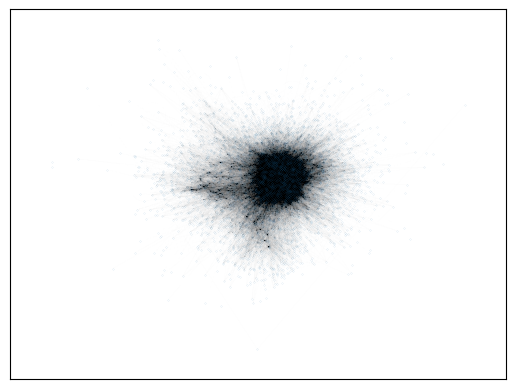

In [21]:
#Show the largest CC
nx.draw_networkx(subgraphs[1],node_size= 0.002,with_labels=False, width = 0.001 )

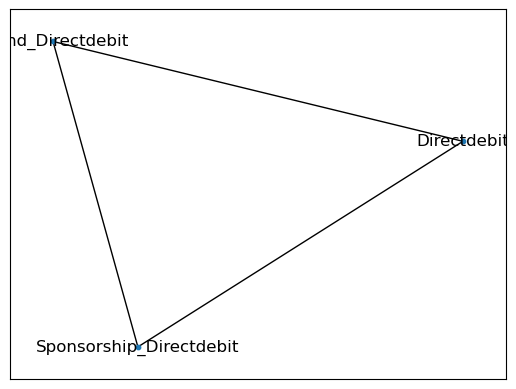

In [29]:
#Show the other CC
nx.draw_networkx(subgraphs[1],node_size= 10,with_labels=True, width =1)

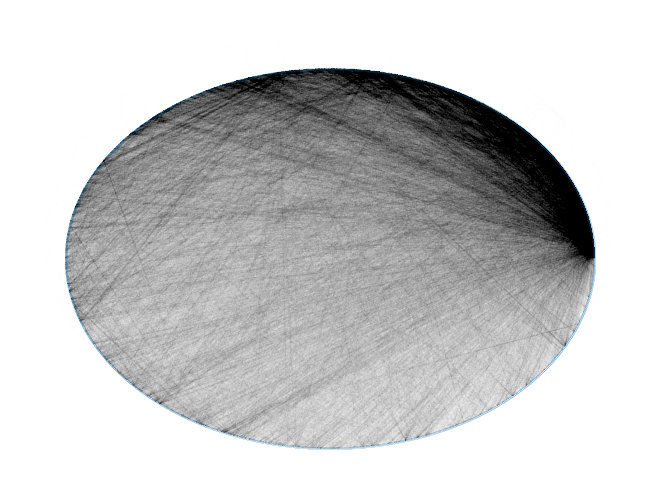

In [26]:
#Show in a circular graph
nx.draw_circular(subgraphs[0],node_size= 0.002,with_labels=False, width = 0.001 )